In [34]:
#script 4  Generalized coordinates with Action and Causal state updatebij 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
import math as m

# Define time settings
T = 200
dt = 0.005
t = np.arange(0, T, dt)
N  = t.size

F = np.zeros(N)
x = np.zeros(N)
x_dot = np.zeros(N)
ya = np.zeros(N)
ya_dot = np.zeros(N)
yb = np.zeros(N)
yb_dot = np.zeros(N)
mu = np.zeros(N)
phi = np.zeros(N)
mu_x = np.zeros(N)
mu_x_dot = np.zeros(N)
u = np.zeros(N)
mu_v = np.zeros(N)
mu_v_dot = np.zeros(N)

x_int = np.zeros(N)

# precisions
#sensor 1
omega_az0 = np.ones(N)*5
omega_az1 = np.ones(N)*5

#sensor 2
omega_bz0 = np.ones(N)*5
omega_bz1 = np.ones(N)*5


# internal precisions
omega = np.ones(N)*10
omega_2 = np.ones(N)*10
#learning rates
alpha = 1       
alpha_u = 1



#initiazation
mu[0] = 30
mu_x[0] = 30
x[0]= 30


for i in np.arange(0,N-1):
    #generative process of movement
    x_dot[i] = u[i]
    x[i+1] = x[i] + dt*x_dot[i]
  
    if i == 0.4*N: 
        x[i+1] = x[i]
        
        
    x_int = x[i]

    ya[i] = x[i]
    ya_dot[i] = x_dot[i]

    yb[i] = x[i] 
    yb_dot[i] = x_dot[i]


    if i >0.15*N:
        ya[i] = x[i]+2
        yb[i] = x[i] 


    if i > 0.3*N:
        ya[i] = x[i]+2
        yb[i] = x[i]  + np.random.randn(1)*1


    # set precisioon matrices for iteration
    PIa_z = np.diag([omega_az0[i],1])
    PIb_z = np.diag([omega_bz0[i],1])
    PI_w = np.diag([1,1])

   
    #relation between internal temp and depth/external temp
    phi[i] = x_int# + np.random.rand(1)*0.1

    # internal temperature estimation
    eps_1 = phi[i] - mu[i] 

    #1st hierarchical prediction error
    mu_prior = 30
    eps_2 = mu[i] - mu_prior
    
    #external depth estimation
    e_x = np.array([[mu_x_dot[i]], [0]]) - (np.array([[-mu_x[i]],[-mu_x_dot[i]]]) + np.array([[mu[i]],[0]]))
    e_ya = np.array([[ya[i]],[ya_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])
    e_yb = np.array([[yb[i]],[yb_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])

    
    dFdmu_x = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PIa_z,e_ya)) - np.dot(np.identity(2),np.dot(PIb_z,e_yb)) 
    dmu_x = np.array([[mu_x_dot[i]], [0]]) - alpha*dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x[0]
    mu_x_dot[i+1] = mu_x_dot[i] +dt*dmu_x[1]



    #Free Energy
    F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))

    #causal state update
    dFdmu = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[i],0]])*np.array([[eps_2],[0]]) - np.array([[omega[i]],[0]])*np.array([[eps_1],[0]])
    dmu = -alpha*dFdmu[0]
    mu[i+1] = mu[i] + dt*dmu[0]



    u_dot = -np.array([0,1]).dot(PIa_z).dot(e_ya) -np.array([0,1]).dot(PIb_z).dot(e_yb) 
    u[i+1] = u[i] + alpha_u*dt*u_dot
    

    
    #   precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    # PI_w = PI_w + dt*dPI_w

    alpha_1 = 0.1
    alpha_2 = 0.1
    alpha_za = 1
    alpha_zb = 1

    # domega = alpha_1*0.5*(1/omega[i] - eps_1**2)
    # domega_2 = alpha_2*0.5*(1/omega_2[i]- eps_2**2)
    # omega[i+1] = omega[i] + dt*domega
    # omega_2[i+1] = omega_2[i] + dt*domega_2

    dPIa_z = alpha_za*0.5*(inv(PIa_z) - np.diag(e_ya.flatten())**2)
    PIa_z = PIa_z + dt*dPIa_z
    omega_az0[i+1] = PIa_z[0,0]
    omega_az1[i+1] = PIa_z[1,1]

    dPIb_z = alpha_zb*0.5*(inv(PIb_z) - np.diag(e_yb.flatten())**2)
    PIb_z = PIb_z + dt*dPIb_z
    omega_bz0[i+1] = PIb_z[0,0]
    omega_bz1[i+1] = PIb_z[1,1]


    #just so the graph wont show zero 
    phi[i+1] = x[i+1]
    ya[i+1] = ya[i]

    F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))


In [5]:
print(eps_1, "eps1")
print(eps_2, "eps2")
print(e_x, "e_x")

print(e_ya, "e_ya  ")
print(e_yb, "e_yb")

print(PI_w, "PI_w")
print(PIa_z, "PIa_z" )
print(PIb_z, "PIb_z")
print(omega[-1], "omega")
print(omega_2[-1], "omega_2")

print(F[-2], "F")

-1.9595064492671987 eps1
-1.9596229857372975 eps2
[[2.19886272e-03]
 [3.84143025e-05]] e_x
[[ 0.0383331 ]
 [-0.00030068]] e_ya  
[[-1.39122267e+00]
 [-3.00683976e-04]] e_yb
[[1 0]
 [0 1]] PI_w
[[10.52745094  0.        ]
 [ 0.          1.0025    ]] PIa_z
[[0.23904037 0.        ]
 [0.         1.0025    ]] PIb_z
10.0 omega
10.0 omega_2
38.17407882199056 F


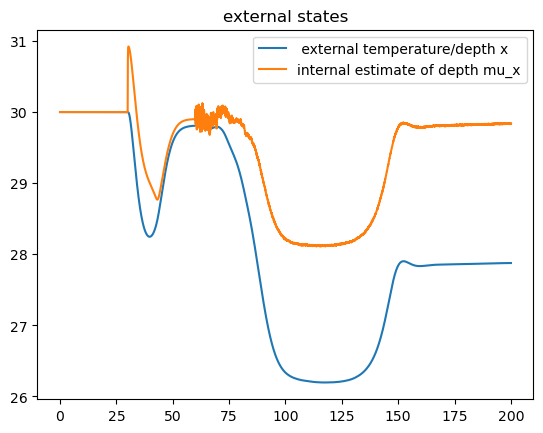

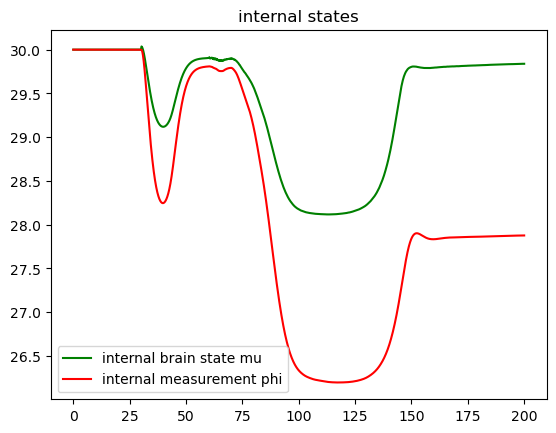

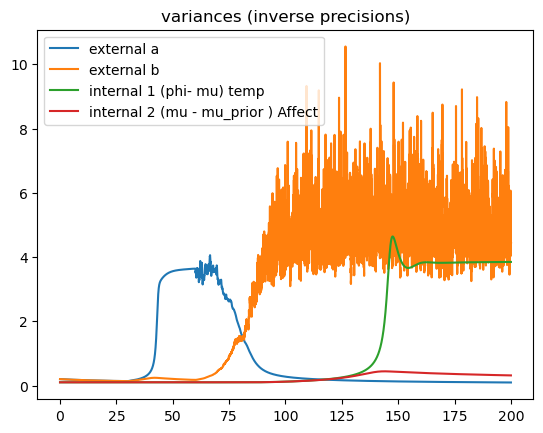

In [33]:
#plot 3

plt.figure()
plt.plot(t, x, label = " external temperature/depth x")
plt.plot(t,mu_x, label = "internal estimate of depth mu_x")
plt.title("external states")
plt.legend()

plt.figure()
plt.plot(t, mu, label = "internal brain state mu" , color = "g")
plt.plot(t, phi, label = "internal measurement phi", color = "r")
plt.title("internal states")
plt.legend()
# plt.plot(mu_dot)

plt.figure()
plt.plot(t,1/omega_az0, label =  "external a")
plt.plot(t,1/omega_bz0, label = "external b")
plt.plot(t, 1/omega, label = "internal 1 (phi- mu) temp")
plt.plot(t, 1/omega_2, label = "internal 2 (mu - mu_prior ) Affect")
plt.title("variances (inverse precisions)")

plt.legend()



In [7]:
#script 4  Generalized coordinates with Action and Causal state updatebij 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
import math as m

# Define time settings
T = 150
dt = 0.005
t = np.arange(0, T, dt)
N  = t.size

F = np.zeros(N)
x = np.zeros(N)
x_dot = np.zeros(N)
ya = np.zeros(N)
ya_dot = np.zeros(N)
yb = np.zeros(N)
yb_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot= np.zeros(N)
phi = np.zeros(N)
phi_dot = np.zeros(N)
mu_x = np.zeros(N)
mu_x_dot = np.zeros(N)
u = np.zeros(N)
mu_v = np.zeros(N)
mu_v_dot = np.zeros(N)

x_int = np.zeros(N)

# precisions
#sensor 1
omega_az0 = np.ones(N)*5
omega_az1 = np.ones(N)*5

#sensor 2
omega_bz0 = np.ones(N)*5
omega_bz1 = np.ones(N)*5


# internal precisions
omega = np.ones(N)*5
omega_2 = np.ones(N)*5

#learning rates
alpha = 1       
alpha_u = 0.1



#initiazation
mu[0] = 30
mu_x[0] = 30
x[0]= 30


for i in np.arange(0,N-1):
    #generative process of movement
    x_dot[i] = u[i]
    x[i+1] = x[i] + dt*x_dot[i]
  
    if i == 0.4*N: 
        x[i+1] = x[i]
        
        
    x_int = x[i+1]

    ya[i] = x[i]
    ya_dot[i] = x_dot[i]

    yb[i] = x[i] 
    yb_dot[i] = x_dot[i]


    if i >0.15*N:
        ya[i] = x[i]+2
        yb[i] = x[i] 


    if i > 0.3*N:
        ya[i] = x[i]+2
        yb[i] = x[i] + np.random.randn(1)*1


    # set precisioon matrices for iteration
    PIa_z = np.diag([omega_az0[i],1])
    PIb_z = np.diag([omega_bz0[i],1])
    PI_w = np.diag([1,1])
    PI_phi = np.diag([omega[i],1] )
   
    #relation between internal temp and depth/external temp
    phi[i] = x_int# + np.random.rand(1)*0.1
    phi_dot[i] = x_dot[i]


    # internal temperature estimation
    eps_1 = np.array([[phi[i]], [phi_dot[i]]]) - np.array([[mu[i]],[0]]) 

    #1st hierarchical prediction error
    mu_prior = 30
    eps_2 = mu[i] - mu_prior
    
    #external depth estimation
    e_x = np.array([[mu_x_dot[i]], [0]]) - (np.array([[-mu_x[i]],[-mu_x_dot[i]]]) + np.array([[mu[i]],[0]]))
    e_ya = np.array([[ya[i]],[ya_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])
    e_yb = np.array([[yb[i]],[yb_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])

    
    dFdmu_x = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PIa_z,e_ya)) - np.dot(np.identity(2),np.dot(PIb_z,e_yb)) 
    dmu_x = np.array([[mu_x_dot[i]], [0]]) - alpha*dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x[0]
    mu_x_dot[i+1] = mu_x_dot[i] +dt*dmu_x[1]

    #Free Energy
    # F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)) - np.log(omega[i]) - np.log(omega_2[i]) )

    #causal state update
    dFdmu = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[i],0]])*np.array([[eps_2],[0]]) +  np.identity(2).dot(np.dot(PI_phi, eps_1))
    dmu = -alpha*dFdmu[0]
    mu[i+1] = mu[i] + dt*dmu[0]



    u_dot = -np.array([0,1]).dot(PIa_z).dot(e_ya) -np.array([0,1]).dot(PIb_z).dot(e_yb) -np.array([0,1]).dot(PI_phi).dot(eps_1)
    u[i+1] = u[i] + alpha_u*dt*u_dot
    

    
    #   precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    # PI_w = PI_w + dt*dPI_w

    alpha_1 = 0.0011
    alpha_2 = 0.1
    alpha_za = 1
    alpha_zb = 1

    #domega = alpha_1*0.5*(1/omega[i] - eps_1**2)
    # domega_2 = alpha_2*0.5*(1/omega_2[i]- eps_2**2)
    #omega[i+1] = omega[i] + dt*domega
    # omega_2[i+1] = omega_2[i] + dt*domega_2

    dPIa_z = alpha_za*0.5*(inv(PIa_z) - np.diag(e_ya.flatten())**2)
    PIa_z = PIa_z + dt*dPIa_z
    omega_az0[i+1] = PIa_z[0,0]
    omega_az1[i+1] = PIa_z[1,1]

    dPIb_z = alpha_zb*0.5*(inv(PIb_z) - np.diag(e_yb.flatten())**2)
    PIb_z = PIb_z + dt*dPIb_z
    omega_bz0[i+1] = PIb_z[0,0]
    omega_bz1[i+1] = PIb_z[1,1]


    #just so the graph wont show zero 
    phi[i+1] = x[i+1]
    




C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_17848\4161877736.py:144: RuntimeWarning: overflow encountered in square
  dPIa_z = alpha_za*0.5*(inv(PIa_z) - np.diag(e_ya.flatten())**2)
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_17848\4161877736.py:149: RuntimeWarning: overflow encountered in square
  dPIb_z = alpha_zb*0.5*(inv(PIb_z) - np.diag(e_yb.flatten())**2)

KeyboardInterrupt



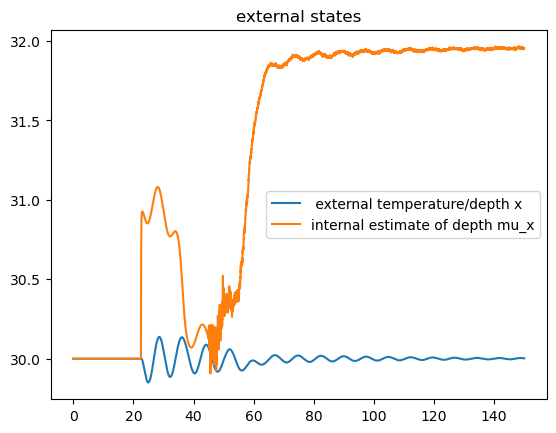

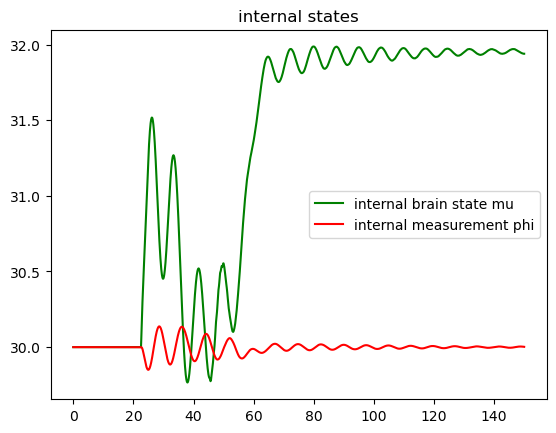

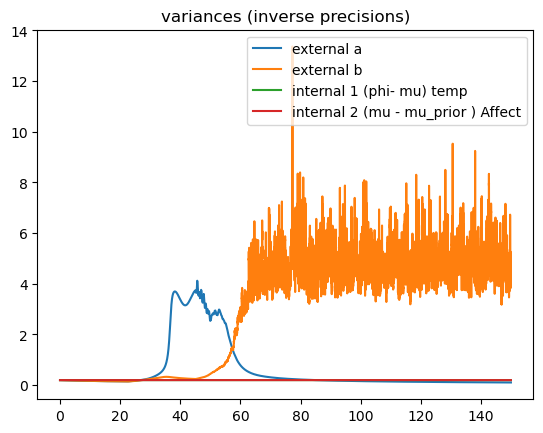

In [ ]:
#plot 3

plt.figure()
plt.plot(t, x, label = " external temperature/depth x")
plt.plot(t,mu_x, label = "internal estimate of depth mu_x")
plt.title("external states")
plt.legend()

plt.figure()
plt.plot(t, mu, label = "internal brain state mu" , color = "g")
plt.plot(t, phi, label = "internal measurement phi", color = "r")
plt.title("internal states")
plt.legend()
# plt.plot(mu_dot)

plt.figure()
plt.plot(t,1/omega_az0, label =  "external a")
plt.plot(t,1/omega_bz0, label = "external b")
plt.plot(t, 1/omega, label = "internal 1 (phi- mu) temp")
plt.plot(t, 1/omega_2, label = "internal 2 (mu - mu_prior ) Affect")
plt.title("variances (inverse precisions)")

plt.legend()
